**Moisture Budget Derivations**

Based on Trenberth and Guillemot 1995 and using somewhat similar notation.

∇∙$\vec{V}$ + ∂ω/∂p = 0  continuity equation (eqn 1)

Where V = u$\hat{i}$ + v$\hat{j}$, ω is the vertical velocity on pressure coordinate (Pa/s), and p is the pressure level (Pa).

w = ∫$_0^∞$qρdz (eqn 2)

Where w the precipitable water defined as the vertical mass-weighted integral of specific humidity q (kg/kg) and ρ is the density of the air.

Employing the hydrostatic balance dp/dz = -gρ this can be written as:

w = ∫$_0^∞$qρdz = 1/g ∫$_0^{p_s}$qρdp (eqn 3)

Where p_s is the surface pressure. *Note the minus sign disappears because the bounds of the integral are flipped. 

Starting with the conservation of water vapor equation:

∂q/∂t + $\vec{V}$∙∇q + ω ∂q/∂p = e-c (eqn 4)

Where e is evaporation and c is condensation.

∇∙(q$\vec{V}$) = q∇∙$\vec{V}$ + $\vec{V}$∙∇q, using the continuity equation (eqn 1) ∇∙(q$\vec{V}$) = -q∂ω/∂p + $\vec{V}$∙∇q, or $\vec{V}$∙∇q = ∇∙(q$\vec{V}$) + q∂ω/∂p. Substituting this, eqn 4 can be expressed in flux form:

∂q/∂t + ∇∙(q$\vec{V}$) + q∂ω/∂p + ω∂q/∂p = ∂q/∂t + ∇∙q$\vec{V}$ + ∂(ωq)/∂p = e-c (eqn 5)

For the vertical integral of eqn 5

1/g∫$_0^{p_s}$∂q/∂tdp + 1/g∫$_0^{p_s}$∇∙(q$\vec{V}$)dp + 1/g∫$_0^{p_s}$∂(ωq)/∂pdp = E-P (eqn 6)

Noting the generic relationship for any A

∂(∫$_0^{p_s}$qdp)/∂t = ∫$_0^{p_s}$∂A/∂tdp + $A_s$∂$p_s$/∂t   Leibniz integral rule (eqn 7a)

∇∙∫$_0^{p_s}$A$\vec{V}$dp = ∫$_0^{p_s}$∇∙(q$\vec{V}$)dp + A_s$\vec{V}_s$∙∇$p_s$   Leibniz integral rule (eqn 7b)

∫$_0^{p_s}$∂Aω/∂pdp = $A_s$$ω_s$ = $A_s$(∂$p_s$/∂t + $\vec{V}_s$∙∇$p_s$) (eqn 7c)

Equ 6 can be rewritten as

∂(1/g∫$_0^{p_s}$qdp)/∂t  - 1/g$q_s$∂$p_s$/∂t + ∇∙1/g∫$_0^{p_s}$q$\vec{V}$dp - 1/g$q_s$$\vec{V}_s$∙∇$p_s$ + 1/gq∂$p_s$/∂t   + 1/gq$\vec{V}_s$∙∇$p_s$ =

∂(1/g∫$_0^{p_s}$qdp)/∂t + ∇∙1/g∫$_0^{p_s}$q$\vec{V}$dp = E-P 

∂w/∂t + ∇∙1/g∫$_0^{p_s}$q$\vec{V}$dp = E-P (eqn 8)


In [368]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import Ngl
from scipy import interpolate

In [369]:
def spheric_dist(lat1,lat2,lon1,lon2):

    R=6367442.76
    # %  Determine proper longitudinal shift.

    l=np.absolute(lon2-lon1)

    l[l>=180]=360-l[l>=180]

    #                  
    #   Convert Decimal degrees to radians.
    # 
    deg2rad=np.pi/180
    lat1=lat1*deg2rad
    lat2=lat2*deg2rad
    l=l*deg2rad

    # 
    #   Compute the distances using Haversine formula
    # 
    
    dist=R*np.arcsin(np.sqrt(((np.sin(l)*np.cos(lat2))**2)+(((np.sin(lat2)*np.cos(lat1))-(np.sin(lat1)*np.cos(lat2)*np.cos(l)))**2)))

    return dist

In [370]:
def get_grid_area(lon_rho,lat_rho):

    I, J=lon_rho.shape
    lon_u=np.zeros((I+1,J))
    lon_u[1:-1,:]=0.5*(lon_rho[0:-1,:]+lon_rho[1:,:])
    lon_u[0,:]=lon_rho[0,:]-0.5*(lon_rho[1,:]-lon_rho[0,:])
    lon_u[-1,:]=lon_rho[-1,:]+0.5*(lon_rho[-1,:]-lon_rho[-2,:])

    lat_u=np.zeros((I+1,J))
    lat_u[1:-1,:]=0.5*(lat_rho[0:-1,:]+lat_rho[1:,:])
    lat_u[0,:]=lat_rho[0,:]-0.5*(lat_rho[1,:]-lat_rho[0,:])
    lat_u[-1,:]=lat_rho[-1,:]+0.5*(lat_rho[-1,:]-lat_rho[-2,:])

    lon_v=np.zeros((I,J+1))
    lon_v[:,1:-1]=0.5*(lon_rho[:,0:-1]+lon_rho[:,1:])
    lon_v[:,0]=lon_rho[:,0]-0.5*(lon_rho[:,1]-lon_rho[:,0])
    lon_v[:,-1]=lon_rho[:,-1]+0.5*(lon_rho[:,-1]-lon_rho[:,-2])

    lat_v=np.zeros((I,J+1))
    lat_v[:,1:-1]=0.5*(lat_rho[:,0:-1]+lat_rho[:,1:])
    #lat_v[:,0]=lat_rho[:,0]-0.5*(lat_rho[:,1]-lat_rho[:,0])
    #lat_v[:,-1]=lat_rho[:,-1]+0.5*(lat_rho[:,-1]-lat_rho[:,-2])
    lat_v[:,0]=-90
    lat_v[:,-1]=90

    dx_rho=np.zeros((I,J))
    dx_rho=spheric_dist(lat_u[0:-1,:],lat_u[1:,:],lon_u[0:-1,:],lon_u[1:,:])
    dy_rho=np.zeros((I,J))
    dy_rho=spheric_dist(lat_v[:,0:-1],lat_v[:,1:], lon_v[:,0:-1],lon_v[:,1:])

    A=dy_rho*dx_rho
    return (A, dx_rho, dy_rho, lat_v, lon_v, lat_u, lon_u)

In [371]:
def meridi_moist_div(VQBar,dp,dx_midy):
    
    g = 9.81 # gravitational constant
    rho_fw = 1000.0; # density of fresh water (kg/m^3)
    
    # Vertically integrate
    VQBardp = VQBar*dp;  # kg/kg m/s Pa
    dp_naned = np.where(np.isnan(VQBardp),np.nan,dp)
    VQBar_2D = np.nansum(VQBardp,0)/np.nansum(dp_naned,0)*1000; #converted to g/kg m/s
    
    VQBar_vertinterp = (1/g)*np.nansum(VQBardp,0); # in kg/m/s (kg/kg m/s Pa s^2/m -> kg/kg m/s kg/m/s^2 s^2/m) 
    # VQBar_vertinterp has the units of kg/m/s 
    # convert to m^2/s by dividing by water density and then multiply by y or x distance (m) to get m^3/s
    VQBar_vertinterp_mid = VQBar_vertinterp[0:-1,:]+((VQBar_vertinterp[1:,:]-VQBar_vertinterp[0:-1,:])/dy_mid)*0.5*dy[0:-1,:];

    VQBar_transport = np.zeros([nlat+1,nlon])
    VQBar_transport[1:-1,:] = VQBar_vertinterp_mid/rho_fw*dx_midy; # m^3/s
    
    VQBar_div = VQBar_transport[1:,:]-VQBar_transport[0:-1,:]; # m^3/s

    return (VQBar_2D, VQBar_transport, VQBar_div)

In [372]:
def zonal_moist_div(UQBar,dp,dy_midx):

    g = 9.81 #gravitational constant
    rho_fw = 1000.0;      # density of fresh water (kg/m^3)
    
    # Vertically integrate
    UQBardp = UQBar*dp;  # kg/kg m/s Pa
    dp_naned = np.where(np.isnan(UQBardp),np.nan,dp)
    UQBar_2D = np.nansum(UQBardp,0)/np.nansum(dp_naned,0)*1000; #converted to g/kg m/s
    
    UQBar_vertinterp = (1/g)*np.nansum(UQBardp,0); # in kg/m/s (kg/kg m/s Pa s^2/m -> kg/kg m/s kg/m/s^2 s^2/m) 
    # UQBar_vertinterp has the units of kg/m/s 
    # convert to m^2/s by dividing by water density and then multiply by y or x distance (m) to get m^3/s
    UQBar_vertinterp_mid = UQBar_vertinterp[:,0:-1]+((UQBar_vertinterp[:,1:]-UQBar_vertinterp[:,0:-1])/dx_mid)*0.5*dx[:,0:-1];
    UQBar_vertinterp_wrap = UQBar_vertinterp[:,-1]+(UQBar_vertinterp[:,0]-UQBar_vertinterp[:,-1])/((dx[:,0]+dx[:,-1])/2)*0.5*dx[:,-1];
    
    UQBar_transport = np.zeros([nlat,nlon+1])
    UQBar_transport[:,1:-1] = UQBar_vertinterp_mid/rho_fw*dy_midx; # m^3/s
    UQBar_transport[:,0] = UQBar_vertinterp_wrap/rho_fw*(dy[:,0]+dy[:,-1])/2; 
    UQBar_transport[:,-1] = UQBar_vertinterp_wrap/rho_fw*(dy[:,0]+dy[:,-1])/2; 

    UQBar_div = UQBar_transport[:,1:]-UQBar_transport[:,0:-1]; # m^3/s
    
    return (UQBar_2D, UQBar_transport, UQBar_div)

In [373]:
def read_CAM_moist_flux_feilds(file):
    
    ds=xr.open_dataset(file)
    
    p = (ds.hyam*ds.P0 + ds.hybm*ds.PS[0,:,:])# mid-point pressure in Pa (ref P0 = 100000Pa)
    # 0 is TOA and -1 is surface
    
    # pressure at interface
    p_i = (ds.hyai*ds.P0 + ds.hybi*ds.PS[0,:,:])# interface pressure in Pa (ref P0 = 100000Pa)
    
    PS = ds.PS[0,:,:] # Pa
    P = (ds.PRECC[0,:,:]+ds.PRECL[0,:,:])*1000 # m/s x 1000 kg/m^3 = kg/m^2/s
    E = ds.QFLX[0,:,:] # kg/m2/s
    
    Q = ds.Q[0,:,:,:]  # kg/kg
    V = ds.V[0,:,:,:]  # m/s 
    U = ds.U[0,:,:,:]  # m/s
    VQbar = ds.VQ[0,:,:,:] # m/s kg/kg 
    UQbar = ds.UQ[0,:,:,:] # m/s kg/kg
    
    lon = ds.lon
    lat = ds.lat
    [nlvl,nlat,nlon] = V.shape
    
    return (p,p_i,PS,P,E,Q,V,U,VQbar,UQbar,lon,lat,nlvl,nlat,nlon)

In [374]:
def read_CAM_moist_flux_feilds_constP_v2(file):
    
    ds=xr.open_dataset(file)
    
    p_org = (ds.hyam*ds.P0 + ds.hybm*ds.PS[0,:,:])# mid-point pressure in Pa (ref P0 = 100000Pa)
    # 0 is TOA and -1 is surface
    
    # pressure at interface
    p_i_org = (ds.hyai*ds.P0 + ds.hybi*ds.PS[0,:,:])# interface pressure in Pa (ref P0 = 100000Pa)
    
    PS = ds.PS[0,:,:] # Pa
    P = (ds.PRECC[0,:,:]+ds.PRECL[0,:,:])*1000 # m/s x 1000 kg/m^3 = kg/m^2/s
    E = ds.QFLX[0,:,:] # kg/m2/s
    
    #lev=np.array([100, 150, 200, 300, 400, 500, 600, 700, 850, 925, 1000])*100 # Pa
    #lev=np.array([50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 825, 850, 875, 900, 925, 950, 975, 1000, 1010])*100 # Pa
    lev=np.array([50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 825, 850, 875, 900, 925, 950, 975, 1000])*100 # Pa
    #lev=np.array([50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 825, 850, 875, 900, 925, 950, 975, 1000, 1010])*100 # Pa
    #lev=np.array([50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 825, 850, 875, 900, 925, 950])*100 # Pa
  
    lon = ds.lon
    lat = ds.lat
    [nlat,nlon] = P.shape
    [nlvl] = lev.shape
    
    p = np.empty([nlvl,nlat,nlon]) 
    Q = np.empty([nlvl,nlat,nlon])
    V = np.empty([nlvl,nlat,nlon])
    U = np.empty([nlvl,nlat,nlon])
    VQbar = np.empty([nlvl,nlat,nlon])
    UQbar = np.empty([nlvl,nlat,nlon])
    
    for j in range(nlat):
        for i in range(nlon):
            p[:,j,i] = lev 
            f = interpolate.interp1d(p_org[:,j,i], ds.Q[0,:,j,i], kind='linear', axis=0, copy=True, bounds_error=False, fill_value=np.nan, assume_sorted=False)
            Q[:,j,i]=f(lev)
            f = interpolate.interp1d(p_org[:,j,i], ds.V[0,:,j,i], kind='linear', axis=0, copy=True, bounds_error=False, fill_value=np.nan, assume_sorted=False)
            V[:,j,i]=f(lev)
            f = interpolate.interp1d(p_org[:,j,i], ds.U[0,:,j,i], kind='linear', axis=0, copy=True, bounds_error=False, fill_value=np.nan, assume_sorted=False)
            U[:,j,i]=f(lev)
            f = interpolate.interp1d(p_org[:,j,i], ds.VQ[0,:,j,i], kind='linear', axis=0, copy=True, bounds_error=False, fill_value=np.nan, assume_sorted=False)
            VQbar[:,j,i]=f(lev)
            f = interpolate.interp1d(p_org[:,j,i], ds.UQ[0,:,j,i], kind='linear', axis=0, copy=True, bounds_error=False, fill_value=np.nan, assume_sorted=False)
            UQbar[:,j,i]=f(lev)

    
    #Q=np.where(Q==1.*10**30,np.nan,Q)
    #V=np.where(V==1.*10**30,np.nan,V)
    #U=np.where(U==1.*10**30,np.nan,U)
    #VQbar=np.where(VQbar==1.*10**30,np.nan,VQbar)
    #UQbar=np.where(UQbar==1.*10**30,np.nan,UQbar)
    
    # pressure at interface
    #p_i = np.empty([nlvl+1,nlat,nlon]) 
    #p_i[1:-1,:,:] = (p[0:-1,:,:]+p[1:,:,:])/2
    #p_i[0,:,:] = p_i_org[0,:,:] # OR 225.52395239 Pa -> 2.25523952 hPa
    #p_i[-1,:,:] = PS
    
    p_naned = np.where(np.isnan(Q),np.nan,p)
    
    p_i = np.empty([nlvl+1,nlat,nlon]) 
    p_i[1:-1,:,:] = (p_naned[0:-1,:,:]+p_naned[1:,:,:])/2
    p_i[0,:,:] = p_i_org[0,:,:] # OR 225.52395239 Pa -> 2.25523952 hPa
    p_i[-1,:,:] = PS
    p_i_ps = np.where(np.isnan(p_i),PS,p_i)
    
    return (p,p_i_ps,PS,P,E,Q,V,U,VQbar,UQbar,lon,lat,nlvl,nlat,nlon)

In [375]:
path='/homes/nburls/MoistureBudgetInMatlab/'
cnt_file='Control_SSTs_CAM5_0.9x1.25_gx1v6.cam.h0.0021-0120._ANN_climatology.nc'
exp_file='PlioceneAno_SSTs_CAM5_0.9x1.25_gx1v6.cam.h0.0021-0120._ANN_climatology.nc'

In [376]:
[p_cnt,p_i_cnt,PS_cnt,P_cnt,E_cnt,Q_cnt,V_cnt,U_cnt,VQbar_cnt,UQbar_cnt,lon,lat,nlvl,nlat,nlon]=read_CAM_moist_flux_feilds_constP_v2(cnt_file)
[p_exp,p_i_exp,PS_exp_exp,P_exp,E_exp,Q_exp,V_exp,U_exp,VQbar_exp,UQbar_exp,lon,lat,nlvl,nlat,nlon]=read_CAM_moist_flux_feilds_constP_v2(exp_file)

#[p_cnt,p_i_cnt,PS_cnt,P_cnt,E_cnt,Q_cnt,V_cnt,U_cnt,VQbar_cnt,UQbar_cnt,lon,lat,nlvl,nlat,nlon]=read_CAM_moist_flux_feilds(cnt_file)
#[p_exp,p_i_exp,PS_exp_exp,P_exp,E_exp,Q_exp,V_exp,U_exp,VQbar_exp,UQbar_exp,lon,lat,nlvl,nlat,nlon]=read_CAM_moist_flux_feilds(exp_file)

In [377]:
#plt.plot(p_i[:,:,:].mean(axis=2).mean(axis=1))
#plt.plot(np.nanmean(np.nanmean(p_i_est[:,:,:],axis=2),axis=1))
#plt.contourf(p_i_est[-1,:,:])
#plt.colorbar()

In [378]:
# Calculate the pressure change (dp) for each grid cell
dp_cnt = p_i_cnt[1:,:,:]-p_i_cnt[0:-1,:,:]
dp_exp = p_i_exp[1:,:,:]-p_i_exp[0:-1,:,:]

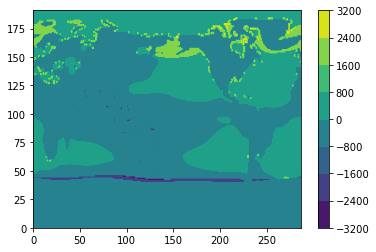

In [380]:
test_dp_diff=dp_cnt-dp_exp
plt.contourf(test_dp_diff[-1,:,:])
plt.colorbar()

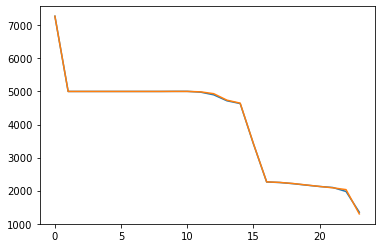

In [381]:
plt.plot(dp_cnt[:,:,:].mean(axis=2).mean(axis=1))
plt.plot(dp_exp[:,:,:].mean(axis=2).mean(axis=1))

In [382]:
# Calculate dx, dy and Area 
[lat_rho,lon_rho]=np.meshgrid(lat,lon);
(A, dx, dy, lat_v, lon_v, lat_u, lon_u)=get_grid_area(lon_rho,lat_rho)
A = np.swapaxes(A,0,1)
dx = np.swapaxes(dx,0,1)
dy = np.swapaxes(dy,0,1)

In [383]:
dx_midy = (dx[0:-1,:]+dx[1:,:])/2;
dy_midx = (dy[:,0:-1]+dy[:,1:])/2; 
dx_mid = (dx[:,0:-1]+dx[:,1:])/2;
dy_mid = (dy[0:-1,:]+dy[1:,:])/2; 

In [384]:
#plt.contourf(lon,lat,A)
#plt.contourf(lon,lat,dx)
#plt.contourf(lat,lon,dy)
#plt.contourf(dx_midy)
#plt.contourf(dy_midx)
#plt.contourf(dx_mid)
#plt.contourf(dy_mid)
#plt.colorbar()

**Decomp of Control Simulation** 

In [385]:
(VQbar_2D_cnt,VQbar_transport_cnt, VQbar_div_cnt) = meridi_moist_div(VQbar_cnt,dp_cnt,dx_midy)

VbarQbar_cnt=V_cnt*Q_cnt
(VbarQbar_2D_cnt,VbarQbar_transport_cnt, VbarQbar_div_cnt) = meridi_moist_div(VbarQbar_cnt,dp_cnt,dx_midy)

VpQpbar_div_cnt=VQbar_div_cnt-VbarQbar_div_cnt

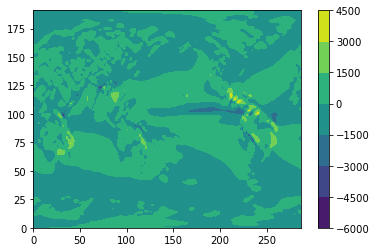

In [386]:
plt.contourf(VQbar_div_cnt)
plt.colorbar()

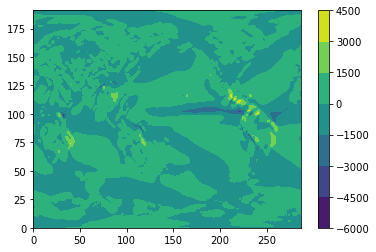

In [387]:
plt.contourf(VbarQbar_div_cnt)
plt.colorbar()

In [388]:
(UQbar_2D_cnt,UQbar_transport_cnt, UQbar_div_cnt) = zonal_moist_div(UQbar_cnt,dp_cnt,dy_midx)

UbarQbar_cnt=U_cnt*Q_cnt
(UbarQbar_2D_cnt,UbarQbar_transport_cnt, UbarQbar_div_cnt) = zonal_moist_div(UbarQbar_cnt,dp_cnt,dy_midx)

UpQpbar_div_cnt=UQbar_div_cnt-UbarQbar_div_cnt

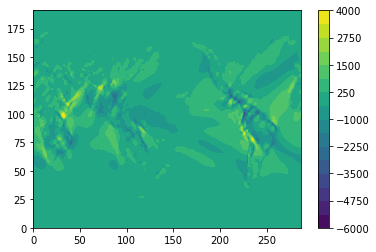

In [389]:
clev=np.linspace(-6000,4000,17)
plt.contourf(UQbar_div_cnt,clev)
plt.colorbar()

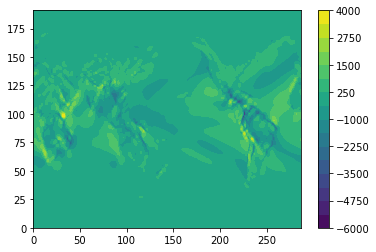

In [390]:
clev=np.linspace(-6000,4000,17)
plt.contourf(UbarQbar_div_cnt,clev)
plt.colorbar()

In [391]:
#plt.contourf(lon,lat,VQBardp[1,:,:])
#plt.contourf(lon,lat,VQBar_vertinterp)
#plt.contourf(lon,lat,dp_naned[-1,:,:])
#plt.contourf(VQBar_div)
#plt.colorbar()

In [392]:
Moisture_Div_cnt = (UQbar_div_cnt+VQbar_div_cnt)/A; #m/s 
#Moisture_Div[0,:] = 0; Moisture_Div[-1,:] = 0; # set moisture div to zero at poles
Moisture_Div_mean_cnt = (UbarQbar_div_cnt+VbarQbar_div_cnt)/A; #m/s 
Moisture_Div_eddy_cnt = (UpQpbar_div_cnt+VpQpbar_div_cnt)/A; #m/s

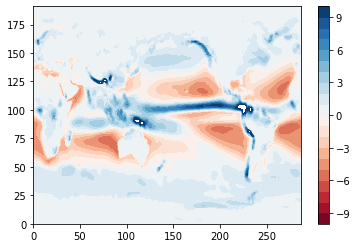

In [393]:
clev=np.linspace(-10,10,21)
plt.contourf((P_cnt-E_cnt)*86400,clev,cmap='RdBu') #convert from kg/m^2/s to mm/day -> ./1000.*1000.*86400
plt.colorbar()

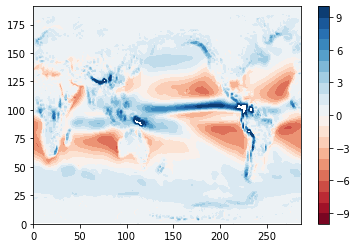

In [394]:
clev=np.linspace(-10,10,21)
plt.contourf(-Moisture_Div_cnt*86400*1000,clev,cmap='RdBu') #convert from m/s to mm/day -> .*1000.*86400
plt.colorbar()

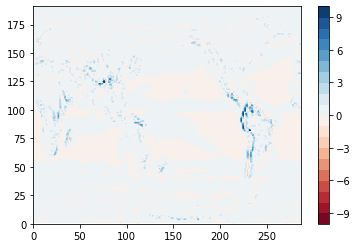

In [395]:
clev=np.linspace(-10,10,21)
plt.contourf(-Moisture_Div_cnt*86400*1000-((P_cnt-E_cnt)*86400),clev,cmap='RdBu') #convert from m/s to mm/day -> .*1000.*86400
plt.colorbar()

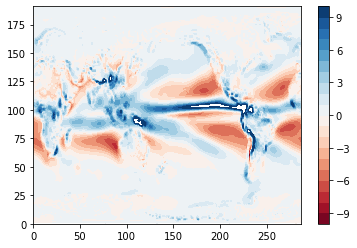

In [396]:
clev=np.linspace(-10,10,21)
plt.contourf(-Moisture_Div_mean_cnt*86400*1000,clev,cmap='RdBu') #convert from m/s to mm/day -> .*1000.*86400
plt.colorbar()

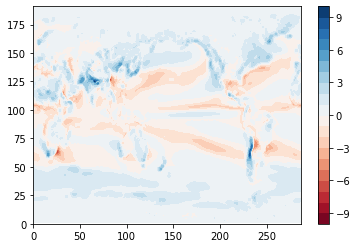

In [397]:
clev=np.linspace(-10,10,21)
plt.contourf(-Moisture_Div_eddy_cnt*86400*1000,clev,cmap='RdBu') #convert from m/s to mm/day -> .*1000.*86400
plt.colorbar()

**Decomp of Pliocene Simulation** 

In [398]:
(VQbar_2D_exp,VQbar_transport_exp, VQbar_div_exp) = meridi_moist_div(VQbar_exp,dp_exp,dx_midy)

VbarQbar_exp=V_exp*Q_exp
(VbarQbar_2D_exp,VbarQbar_transport_exp, VbarQbar_div_exp) = meridi_moist_div(VbarQbar_exp,dp_exp,dx_midy)
# Plus futher decomp into dynamic and thermodynamic
VcntQanobar_exp=V_exp*(Q_exp-Q_cnt)
(VcntQanobar_2D_exp,VcntQanobar_transport_exp,VcntQanobar_div_exp) = meridi_moist_div(VcntQanobar_exp,dp_exp,dx_midy)
VanoQcntbar_exp=(V_exp-V_cnt)*Q_cnt
(VanoQcntbar_2D_exp,VanoQcntbar_transport_exp,VanoQcntbar_div_exp) = meridi_moist_div(VanoQcntbar_exp,dp_exp,dx_midy)
VanoQanobar_exp=(V_exp-V_cnt)*(Q_exp-Q_cnt)
(VanoQanobar_2D_exp,VanoQanobar_transport_exp,VanoQanobar_div_exp) = meridi_moist_div(VanoQanobar_exp,dp_exp,dx_midy)

VpQpbar_div_exp=VQbar_div_exp-VbarQbar_div_exp

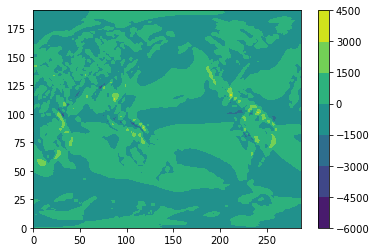

In [399]:
plt.contourf(VQbar_div_exp)
plt.colorbar()

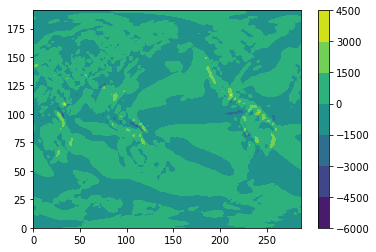

In [400]:
plt.contourf(VbarQbar_div_exp)
plt.colorbar()

In [401]:
(UQbar_2D_exp,UQbar_transport_exp, UQbar_div_exp) = zonal_moist_div(UQbar_exp,dp_exp,dy_midx)

UbarQbar_exp=U_exp*Q_exp
(UbarQbar_2D_exp,UbarQbar_transport_exp, UbarQbar_div_exp) = zonal_moist_div(UbarQbar_exp,dp_exp,dy_midx)

# Plus futher decomp into dynamic and thermodynamic
UcntQanobar_exp=U_exp*(Q_exp-Q_cnt)
(UcntQanobar_2D_exp,UcntQanobar_transport_exp,UcntQanobar_div_exp) = zonal_moist_div(UcntQanobar_exp,dp_exp,dy_midx)
UanoQcntbar_exp=(U_exp-U_cnt)*Q_cnt
(UanoQcntbar_2D_exp,UanoQcntbar_transport_exp,UanoQcntbar_div_exp) = zonal_moist_div(UanoQcntbar_exp,dp_exp,dy_midx)
UanoQanobar_exp=(U_exp-U_cnt)*(Q_exp-Q_cnt)
(UanoQanobar_2D_exp,UanoQanobar_transport_exp,UanoQanobar_div_exp) = zonal_moist_div(UanoQanobar_exp,dp_exp,dy_midx)

UpQpbar_div_exp=UQbar_div_exp-UbarQbar_div_exp

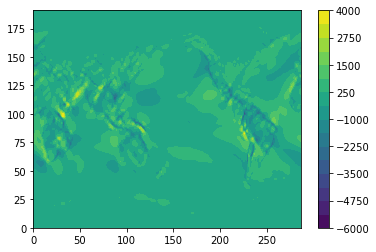

In [402]:
clev=np.linspace(-6000,4000,17)
plt.contourf(UQbar_div_exp,clev)
plt.colorbar()

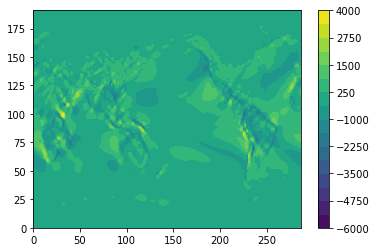

In [403]:
clev=np.linspace(-6000,4000,17)
plt.contourf(UbarQbar_div_exp,clev)
plt.colorbar()

In [404]:
#plt.contourf(lon,lat,VQBardp[1,:,:])
#plt.contourf(lon,lat,VQBar_vertinterp)
#plt.contourf(lon,lat,dp_naned[-1,:,:])
#plt.contourf(VQBar_div)
#plt.colorbar()

In [405]:
Moisture_Div_exp = (UQbar_div_exp+VQbar_div_exp)/A; #m/s 
#Moisture_Div[0,:] = 0; Moisture_Div[-1,:] = 0; # set moisture div to zero at poles

Moisture_Div_mean_exp = (UbarQbar_div_exp+VbarQbar_div_exp)/A; #m/s 
Moisture_Div_mean_thermo_exp = (UcntQanobar_div_exp+VcntQanobar_div_exp)/A; #m/s 
Moisture_Div_mean_dynamic_exp = (UanoQcntbar_div_exp+VanoQcntbar_div_exp)/A; #m/s 
Moisture_Div_mean_purt_exp = (UanoQanobar_div_exp+VanoQanobar_div_exp)/A; #m/s 

Moisture_Div_eddy_exp = (UpQpbar_div_exp+VpQpbar_div_exp)/A; #m/s


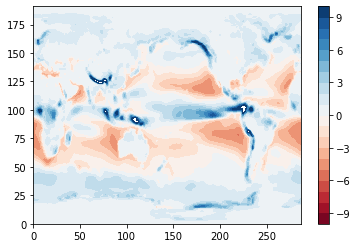

In [406]:
clev=np.linspace(-10,10,21)
plt.contourf((P_exp-E_exp)*86400,clev,cmap='RdBu') #convert from kg/m^2/s to mm/day -> ./1000.*1000.*86400
plt.colorbar()

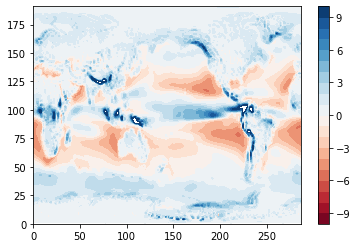

In [407]:
clev=np.linspace(-10,10,21)
plt.contourf(-Moisture_Div_exp*86400*1000,clev,cmap='RdBu') #convert from m/s to mm/day -> .*1000.*86400
plt.colorbar()

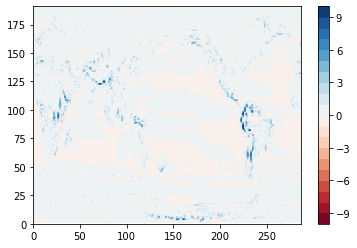

In [408]:
clev=np.linspace(-10,10,21)
plt.contourf(-Moisture_Div_exp*86400*1000-((P_exp-E_exp)*86400),clev,cmap='RdBu') #convert from m/s to mm/day -> .*1000.*86400
plt.colorbar()

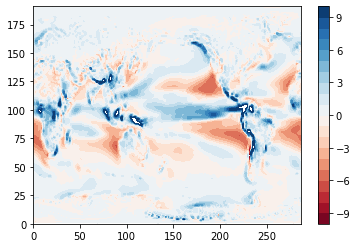

In [409]:
clev=np.linspace(-10,10,21)
plt.contourf(-Moisture_Div_mean_exp*86400*1000,clev,cmap='RdBu') #convert from m/s to mm/day -> .*1000.*86400
plt.colorbar()

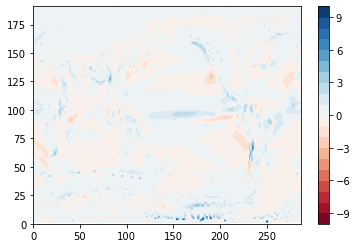

In [410]:
clev=np.linspace(-10,10,21)
plt.contourf(-Moisture_Div_mean_thermo_exp*86400*1000,clev,cmap='RdBu') #convert from m/s to mm/day -> .*1000.*86400
plt.colorbar()

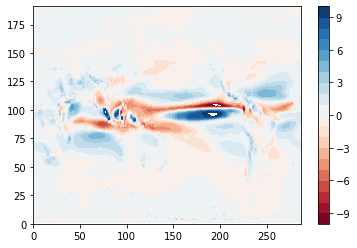

In [411]:
clev=np.linspace(-10,10,21)
plt.contourf(-Moisture_Div_mean_dynamic_exp*86400*1000,clev,cmap='RdBu') #convert from m/s to mm/day -> .*1000.*86400
plt.colorbar()

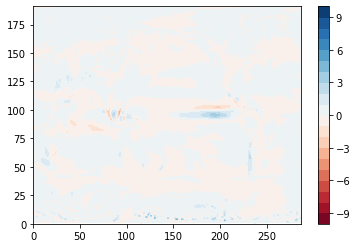

In [412]:
clev=np.linspace(-10,10,21)
plt.contourf(-Moisture_Div_mean_purt_exp*86400*1000,clev,cmap='RdBu') #convert from m/s to mm/day -> .*1000.*86400
plt.colorbar()

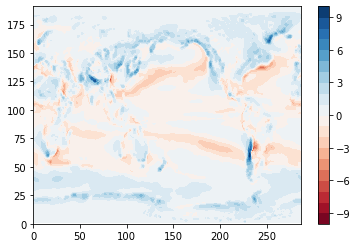

In [413]:
clev=np.linspace(-10,10,21)
plt.contourf(-Moisture_Div_eddy_exp*86400*1000,clev,cmap='RdBu') #convert from m/s to mm/day -> .*1000.*86400
plt.colorbar()

Moisture_Div_exp = (UQbar_div_exp+VQbar_div_exp)/A; #m/s 
Moisture_Div_mean_exp = (UbarQbar_div_exp+VbarQbar_div_exp)/A; #m/s 
Moisture_Div_eddy_exp = (UpQpbar_div_exp+VpQpbar_div_exp)/A; #m/s

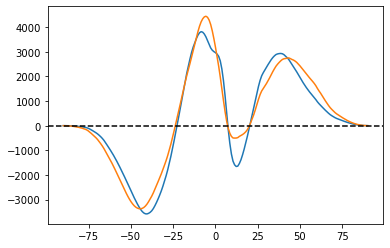

In [414]:
#Get Zonal-Mean Meridional Moisture Transport (VQbar_transport in m^3/s)
VQbar_transport_cnt_ZM=np.mean(VQbar_transport_cnt, axis=1)
VQbar_transport_exp_ZM=np.mean(VQbar_transport_exp, axis=1)

fig, ax = plt.subplots()
plt.plot(lat_v[0,:],VQbar_transport_cnt_ZM) # cannot use lat as calculated at mid points
plt.plot(lat_v[0,:],VQbar_transport_exp_ZM) # cannot use lat as calculated at mid points
ax.axhline(0, linestyle='--', color='k') # horizontal lines

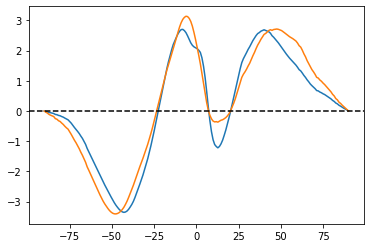

In [415]:
VQbar_2D_cnt_ZM=np.mean(VQbar_2D_cnt, axis=1)
VQbar_2D_exp_ZM=np.mean(VQbar_2D_exp, axis=1)

fig, ax = plt.subplots()
plt.plot(lat,VQbar_2D_cnt_ZM)
plt.plot(lat,VQbar_2D_exp_ZM)
ax.axhline(0, linestyle='--', color='k') # horizontal lines

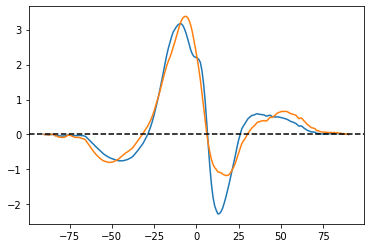

In [416]:
VbarQbar_2D_cnt_ZM=np.mean(VbarQbar_2D_cnt, axis=1)
VbarQbar_2D_exp_ZM=np.mean(VbarQbar_2D_exp, axis=1)

fig, ax = plt.subplots()
plt.plot(lat,VbarQbar_2D_cnt_ZM)
plt.plot(lat,VbarQbar_2D_exp_ZM)
ax.axhline(0, linestyle='--', color='k') # horizontal lines

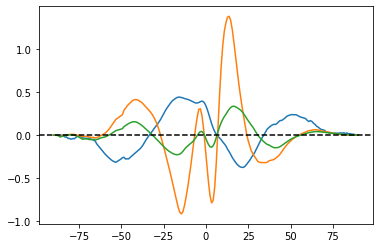

In [417]:
VanoQcntbar_2D_exp_ZM=np.mean(VanoQcntbar_2D_exp, axis=1)
VcntQanobar_2D_exp_ZM=np.mean(VcntQanobar_2D_exp, axis=1)
VanoQanobar_2D_exp_ZM=np.mean(VanoQanobar_2D_exp, axis=1)

fig, ax = plt.subplots()
plt.plot(lat,VcntQanobar_2D_exp_ZM)
plt.plot(lat,VanoQcntbar_2D_exp_ZM)
plt.plot(lat,VanoQanobar_2D_exp_ZM)
ax.axhline(0, linestyle='--', color='k') # horizontal lines

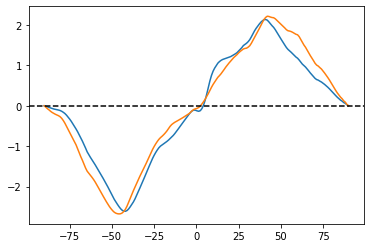

In [418]:
VpQpbar_2D_cnt_ZM=np.mean(VQbar_2D_cnt-VbarQbar_2D_cnt, axis=1)
VpQpbar_2D_exp_ZM=np.mean(VQbar_2D_exp-VbarQbar_2D_exp, axis=1)

fig, ax = plt.subplots()
plt.plot(lat,VpQpbar_2D_cnt_ZM)
plt.plot(lat,VpQpbar_2D_exp_ZM)
ax.axhline(0, linestyle='--', color='k') # horizontal lines

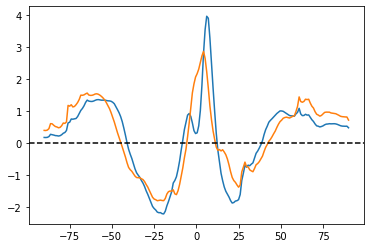

In [419]:
#Get Zonal-Mean P-E
PmE_cnt_ZM=np.mean((P_cnt-E_cnt)*86400, axis=1)
PmE_exp_ZM=np.mean((P_exp-E_exp)*86400, axis=1)

fig, ax = plt.subplots()
plt.plot(lat,PmE_cnt_ZM)
plt.plot(lat,PmE_exp_ZM)
ax.axhline(0, linestyle='--', color='k') # horizontal lines

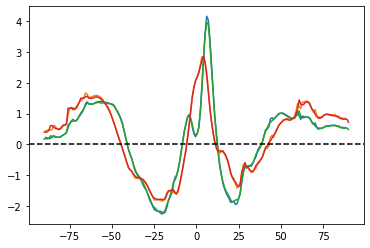

In [420]:
#Get Zonal-Mean Moisture flux divergence 

Moisture_Div_cnt_ZM=-np.mean(Moisture_Div_cnt*86400*1000, axis=1)
Moisture_Div_exp_ZM=-np.mean(Moisture_Div_exp*86400*1000, axis=1)


fig, ax = plt.subplots()
plt.plot(lat[1:-2],Moisture_Div_cnt_ZM[1:-2])
plt.plot(lat[1:-2],Moisture_Div_exp_ZM[1:-2])
plt.plot(lat,PmE_cnt_ZM)
plt.plot(lat,PmE_exp_ZM)
ax.axhline(0, linestyle='--', color='k') # horizontal lines

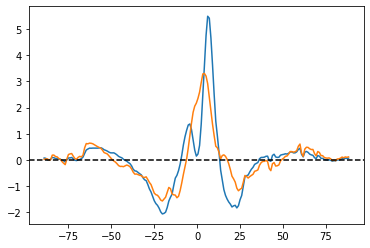

In [421]:
#Get Zonal-Mean Time-Mean Moisture flux divergence 
Moisture_Div_mean_cnt_ZM=-np.mean(Moisture_Div_mean_cnt*86400*1000, axis=1)
Moisture_Div_mean_exp_ZM=-np.mean(Moisture_Div_mean_exp*86400*1000, axis=1)


fig, ax = plt.subplots()
plt.plot(lat[1:-2],Moisture_Div_mean_cnt_ZM[1:-2])
plt.plot(lat[1:-2],Moisture_Div_mean_exp_ZM[1:-2])
ax.axhline(0, linestyle='--', color='k') # horizontal lines

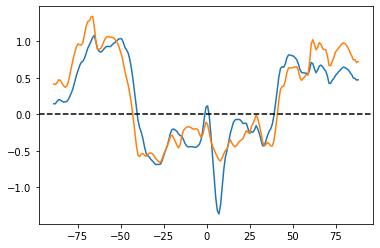

In [422]:
#Get Zonal-Mean Eddy Moisture flux divergence 
Moisture_Div_eddy_cnt_ZM=-np.mean(Moisture_Div_eddy_cnt*86400*1000, axis=1)
Moisture_Div_eddy_exp_ZM=-np.mean(Moisture_Div_eddy_exp*86400*1000, axis=1)


fig, ax = plt.subplots()
plt.plot(lat[1:-2],Moisture_Div_eddy_cnt_ZM[1:-2])
plt.plot(lat[1:-2],Moisture_Div_eddy_exp_ZM[1:-2])
ax.axhline(0, linestyle='--', color='k') # horizontal lines

In [423]:
# Estimate Zonal-Mean Meridional Moisture Flux transport (VQbar_transport in m^3/s) from E-P
rho_fw=1000.0

EmP_cnt_ZM=np.mean((E_cnt-P_cnt), axis=1) #kg/m^2/s
EmP_exp_ZM=np.mean((E_exp-P_exp), axis=1) #kg/m^2/s

dy_ZM=np.mean(dy, axis=1) # meters
dx_ZM=np.mean(dx, axis=1) # meters

VQbar_transport_cnt_ZM_implied_v1=EmP_cnt_ZM*dx_ZM*dy_ZM # kg/s (kg/m^2/s * m * m)
VQbar_transport_exp_ZM_implied_v1=EmP_exp_ZM*dx_ZM*dy_ZM # kg/s (kg/m^2/s * m * m)

VQbar_transport_cnt_ZM_implied = np.zeros([nlat+1])
VQbar_transport_exp_ZM_implied = np.zeros([nlat+1])
for j in range(nlat):
    if j==0:
        VQbar_transport_cnt_ZM_implied[j+1]=VQbar_transport_cnt_ZM_implied_v1[0]/rho_fw+VQbar_transport_cnt_ZM[0] #kg/s / kg/m^3 -> m^3/s
        VQbar_transport_exp_ZM_implied[j+1]=VQbar_transport_exp_ZM_implied_v1[0]/rho_fw+VQbar_transport_exp_ZM[0] #kg/s / kg/m^3 -> m^3/s
    else:
        VQbar_transport_cnt_ZM_implied[j+1]=sum(VQbar_transport_cnt_ZM_implied_v1[0:j+1])/rho_fw+VQbar_transport_cnt_ZM[0] #kg/s / kg/m^3 -> m^3/s
        VQbar_transport_exp_ZM_implied[j+1]=sum(VQbar_transport_exp_ZM_implied_v1[0:j+1])/rho_fw+VQbar_transport_exp_ZM[0] #kg/s / kg/m^3 -> m^3/s
    #print(j)

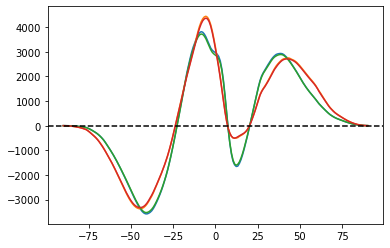

In [424]:
#Plot Zonal-Mean Meridional Moisture Flux implied (VQbar_transport in m^3/s version)

fig, ax = plt.subplots()
plt.plot(lat_v[0,:],VQbar_transport_cnt_ZM) # cannot use lat as calculated at mid points
plt.plot(lat_v[0,:],VQbar_transport_exp_ZM) # cannot use lat as calculated at mid points
plt.plot(lat_v[0,:],VQbar_transport_cnt_ZM_implied)
plt.plot(lat_v[0,:],VQbar_transport_exp_ZM_implied)
ax.axhline(0, linestyle='--', color='k') # horizontal lines

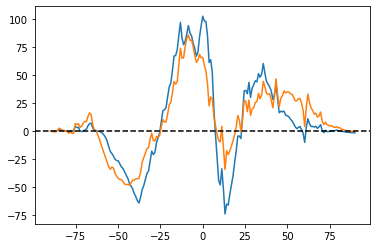

In [425]:
#Plot Zonal-Mean Meridional Moisture Flux implied DIFF (VQbar_transport in m^3/s version)

fig, ax = plt.subplots()
plt.plot(lat_v[0,:],VQbar_transport_cnt_ZM-VQbar_transport_cnt_ZM_implied) # cannot use lat as calculated at mid points
plt.plot(lat_v[0,:],VQbar_transport_exp_ZM-VQbar_transport_exp_ZM_implied) # cannot use lat as calculated at mid points
ax.axhline(0, linestyle='--', color='k') # horizontal lines

In [426]:
#Estimate the Zonal-Mean Meridional Moisture Flux (g/kg m/s)

g = 9.81 # gravitational constant 

# Vertically integrate dp
VQBardp_cnt = VQbar_cnt*dp_cnt;  # kg/kg m/s Pa
dp_naned_cnt = np.where(np.isnan(VQBardp_cnt),np.nan,dp_cnt)
dp_naned_int_cnt=np.nansum(dp_naned_cnt,0)

VQBardp_exp = VQbar_exp*dp_exp;  # kg/kg m/s Pa
dp_naned_exp = np.where(np.isnan(VQBardp_exp),np.nan,dp_exp)
dp_naned_int_exp=np.nansum(dp_naned_exp,0)

p_naned_int_cnt_ZM=np.nanmean(dp_naned_int_cnt, axis=1);
p_naned_int_exp_ZM=np.nanmean(dp_naned_int_exp, axis=1);

#VQbar_2D_cnt_ZM_implied=VQbar_transport_cnt_ZM_implied*rho_fw/dx_ZM*g/p_naned_int_cnt_ZM*1000
# (m^3/s * 1000kg/m^3 / m -> kg/m/s and then kg/m/s * m/s^2 / kg/m/s^2 -> kg/kg m/s * 1000g/kg)

#VQbar_2D_exp_ZM_implied=VQbar_transport_exp_ZM_implied*rho_fw/dx_ZM*g/p_naned_int_exp_ZM*1000
# (m^3/s * 1000kg/m^3 / m -> kg/m/s and then kg/m/s * m/s^2 / kg/m/s^2 -> kg/kg m/s * 1000g/kg)

dx_midy_ZM = np.mean(dx_midy, axis=1) # meters

p_naned_int_cnt_ZM_mid = (p_naned_int_cnt_ZM[0:-1]+p_naned_int_cnt_ZM[1:])/2;
p_naned_int_exp_ZM_mid = (p_naned_int_exp_ZM[0:-1]+p_naned_int_exp_ZM[1:])/2;
 
VQbar_2D_cnt_ZM_implied = np.zeros([nlat+1])
VQbar_2D_exp_ZM_implied = np.zeros([nlat+1])

VQbar_2D_cnt_ZM_implied[1:-1]=VQbar_transport_cnt_ZM_implied[1:-1]*rho_fw/dx_midy_ZM*g/p_naned_int_cnt_ZM_mid*1000
# (m^3/s * 1000kg/m^3 / m -> kg/m/s and then kg/m/s * m/s^2 / kg/m/s^2 -> kg/kg m/s * 1000g/kg)

VQbar_2D_exp_ZM_implied[1:-1]=VQbar_transport_exp_ZM_implied[1:-1]*rho_fw/dx_midy_ZM*g/p_naned_int_exp_ZM_mid*1000
# (m^3/s * 1000kg/m^3 / m -> kg/m/s and then kg/m/s * m/s^2 / kg/m/s^2 -> kg/kg m/s * 1000g/kg)

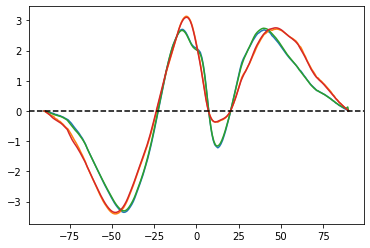

In [427]:
VQbar_2D_cnt_ZM_implied_mid = (VQbar_2D_cnt_ZM_implied[1:]+VQbar_2D_cnt_ZM_implied[0:-1])/2
VQbar_2D_exp_ZM_implied_mid = (VQbar_2D_exp_ZM_implied[1:]+VQbar_2D_exp_ZM_implied[0:-1])/2

fig, ax = plt.subplots()
plt.plot(lat,VQbar_2D_cnt_ZM)
plt.plot(lat,VQbar_2D_exp_ZM)
plt.plot(lat_v[0,:],VQbar_2D_cnt_ZM_implied)
plt.plot(lat_v[0,:],VQbar_2D_exp_ZM_implied)
#plt.plot(lat,VQbar_2D_cnt_ZM_implied_mid)
#plt.plot(lat,VQbar_2D_exp_ZM_implied_mid)
ax.axhline(0, linestyle='--', color='k') # horizontal lines

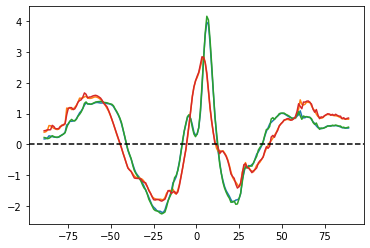

In [428]:
# Comparing
VQbar_div_cnt_ZM=-np.mean(VQbar_div_cnt*86400*1000, axis=1)/np.mean(A, axis=1) #convert from m/s to mm/day -> *1000mm/m*86400s/day
VQbar_div_exp_ZM=-np.mean(VQbar_div_exp*86400*1000, axis=1)/np.mean(A, axis=1) #convert from m/s to mm/day -> *1000mm/m*86400s/day

PmE_cnt_ZM2=np.mean((P_cnt-E_cnt)*86400, axis=1) #convert from kg/m^2/s to mm/day -> ./1000.*1000.*86400
PmE_exp_ZM2=np.mean((P_exp-E_exp)*86400, axis=1) #convert from kg/m^2/s to mm/day -> ./1000.*1000.*86400

fig, ax = plt.subplots()
plt.plot(lat[1:-1],PmE_cnt_ZM2[1:-1])
plt.plot(lat[1:-1],PmE_exp_ZM2[1:-1])
plt.plot(lat[1:-1],VQbar_div_cnt_ZM[1:-1])
plt.plot(lat[1:-1],VQbar_div_exp_ZM[1:-1])
ax.axhline(0, linestyle='--', color='k') # horizontal lines

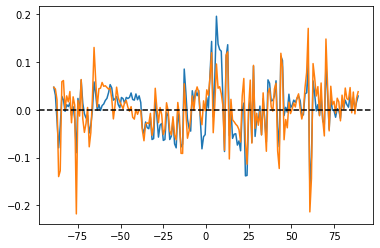

In [429]:
fig, ax = plt.subplots()
plt.plot(lat[1:-1],VQbar_div_cnt_ZM[1:-1]-PmE_cnt_ZM2[1:-1])
plt.plot(lat[1:-1],VQbar_div_exp_ZM[1:-1]-PmE_exp_ZM2[1:-1])
ax.axhline(0, linestyle='--', color='k') # horizontal lines